<a href="https://colab.research.google.com/github/chenweioh/Observational-Data-Analysis-R/blob/main/Inverse_Probability_of_Treatment_Weighting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using Inverse Probability Weighting (IPW) and Marginal Structural Models (MSMs) for Causal Inference: A Practice

Running this cell will display the first few rows of the dataset rhc, allowing you to confirm that the data has been loaded successfully.

# Explanation of the Code
* Installing Packages: The if (!requireNamespace("package_name", quietly = TRUE))
install.packages("package_name") checks if each package is installed, and if not, installs it. This is useful for Colab, where packages may not be pre-installed.
* Loading Data: The load(url(...)) function reads the data directly from the provided URL.
* Previewing Data: head(rhc) displays the first few rows of the data, as View() is not available in Colab.

In [64]:
# Install necessary packages if not already installed
if (!requireNamespace("tableone", quietly = TRUE)) install.packages("tableone")
if (!requireNamespace("ipw", quietly = TRUE)) install.packages("ipw")
if (!requireNamespace("sandwich", quietly = TRUE)) install.packages("sandwich")
if (!requireNamespace("survey", quietly = TRUE)) install.packages("survey")

# Load the packages
library(tableone)
library(ipw)
library(sandwich)  # for robust variance estimation
library(survey)

# Read in the data
load(url("https://hbiostat.org/data/repo/rhc.sav"))

# Display the first few rows of the data as a preview
head(rhc)


,cat1,cat2,ca,sadmdte,dschdte,dthdte,lstctdte,death,cardiohx,chfhx,⋯,meta,hema,seps,trauma,ortho,adld3p,urin1,race,income,ptid
,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<int>,<int>,⋯,<fct>,<fct>,<fct>,<fct>,<fct>,<int>,<dbl>,<fct>,<fct>,<chr>
1,COPD,NA,Yes,11142,11151,NA,11382,No,0,0,⋯,No,No,No,No,No,0,NA,white,Under $11k,00005
2,MOSF w/Sepsis,NA,No,11799,11844,11844,11844,Yes,1,1,⋯,No,No,Yes,No,No,NA,1437,white,Under $11k,00007
3,MOSF w/Malignancy,MOSF w/Sepsis,Yes,12083,12143,NA,12400,No,0,0,⋯,No,No,No,No,No,NA,599,white,$25-$50k,00009
4,ARF,NA,No,11146,11183,11183,11182,Yes,0,0,⋯,No,No,No,No,No,NA,NA,white,$11-$25k,00010
5,MOSF w/Sepsis,NA,No,12035,12037,12037,12036,Yes,0,0,⋯,No,No,No,No,No,NA,64,white,Under $11k,00011
6,COPD,NA,No,12389,12396,NA,12590,No,0,1,⋯,No,No,No,No,No,0,242,white,Under $11k,00012


In [65]:
# Create each variable and confirm it works as expected
# Convert specific categorical variables to numeric (binary) values
ARF <- as.numeric(rhc$cat1 == "ARF")
CHF <- as.numeric(rhc$cat1 == "CHF")
Cirr <- as.numeric(rhc$cat1 == "Cirrhosis")
colcan <- as.numeric(rhc$cat1 == "Colon Cancer")
Coma <- as.numeric(rhc$cat1 == "Coma")
COPD <- as.numeric(rhc$cat1 == "COPD")
lungcan <- as.numeric(rhc$cat1 == "Lung Cancer")
MOSF <- as.numeric(rhc$cat1 == "MOSF w/Malignancy")
sepsis <- as.numeric(rhc$cat1 == "MOSF w/Sepsis")
female <- as.numeric(rhc$sex == "Female")
died <- as.numeric(rhc$death == "Yes")
treatment <- as.numeric(rhc$swang1 == "RHC")

# Directly assign other variables
age <- rhc$age
meanbp1 <- rhc$meanbp1
aps <- rhc$aps1


# After confirming each variable, combine them into a new data frame
rhc_simplified <- data.frame(ARF, CHF, Cirr, colcan, Coma, COPD, lungcan, MOSF,
                             sepsis, female, died, age, treatment, meanbp1, aps)

# View the first few rows of the simplified dataset
head(rhc_simplified)


,ARF,CHF,Cirr,colcan,Coma,COPD,lungcan,MOSF,sepsis,female,died,age,treatment,meanbp1,aps
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,0,0,0,0,0,1,0,0,0,0,0,70.25098,0,41,46
2,0,0,0,0,0,0,0,0,1,1,1,78.17896,1,63,50
3,0,0,0,0,0,0,0,1,0,1,0,46.09198,1,57,82
4,1,0,0,0,0,0,0,0,0,1,1,75.33197,0,55,48
5,0,0,0,0,0,0,0,0,1,0,1,67.90997,1,65,72
6,0,0,0,0,0,1,0,0,0,1,0,86.07794,0,115,38


#Explanation
* cbind: Combines each individual variable (ARF, CHF, Cirr, etc.) into columns of a matrix. Each vector should have the same length (5735 rows).
* data.frame(): Converts the resulting matrix into a data frame called mydata.
* head(mydata): Displays the first few rows to check the final structure.

In [66]:
# Create new dataset using cbind and then convert to data frame
mydata <- cbind(ARF, CHF, Cirr, colcan, Coma, lungcan, MOSF, sepsis,
                age, female, meanbp1, aps, treatment, died)
mydata <- data.frame(mydata)

# View the first few rows of the new dataset
head(mydata)

,ARF,CHF,Cirr,colcan,Coma,lungcan,MOSF,sepsis,age,female,meanbp1,aps,treatment,died
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,0,0,0,0,0,0,0,70.25098,0,41,46,0,0
2,0,0,0,0,0,0,0,1,78.17896,1,63,50,1,1
3,0,0,0,0,0,0,1,0,46.09198,1,57,82,1,0
4,1,0,0,0,0,0,0,0,75.33197,1,55,48,0,1
5,0,0,0,0,0,0,0,1,67.90997,0,65,72,1,1
6,0,0,0,0,0,0,0,0,86.07794,1,115,38,0,0


In [67]:
#Fit a Propensity Score Model
psmodel <-glm(treatment ~ age + female + meanbp1 + ARF + CHF + Cirr + colcan +
               Coma + lungcan + MOSF + sepsis, family =binomial(link="logit"),data=mydata)

#Calculate the propensity score for each subject
ps <- predict(psmodel, type = "response")

#View the first few propensity scores
head(ps)

1          2          3          4          5          6 
0.19771316 0.55142639 0.40957979 0.39008902 0.59543476 0.08070615

#Create Weights:
```
ifelse(mydata$treatment == 1, 1 / ps, 1 / (1 - ps))
```
calculates the inverse probability weights:
* For treated subjects (treatment == 1), the weight is 1 / ps.
* For untreated subjects (treatment == 0), the weight is 1 / (1 - ps).

#Apply Weights to Data:

```
svydesign(ids = ~ 1, data = mydata, weights = ~ weight)
```
 creates a survey design object called weighteddata that incorporates the inverse probability weights. This object is used in functions that support survey weights, like svyCreateTableOne.

#Define Variables to Check Balance:

xvars lists the covariates to be assessed for balance across treatment groups. You can modify this list based on the variables in your dataset.

#Create Weighted Table 1:
```
svyCreateTableOne(vars = xvars, strata = "treatment", data = weighteddata, test = FALSE)
```
generates a table that summarizes covariate balance between treatment groups, using the weights to adjust for differences. strata = "treatment" specifies that the table should be stratified by the treatment variable.

#Print Table with Standardized Mean Differences (SMD):
```
print(weightedtable, smd = TRUE)
```
displays the table with standardized mean differences (SMD) for each covariate. SMD values close to 0 indicate better balance across treatment groups, while larger values suggest imbalance.

In [68]:
#Create weights
weight <- ifelse(mydata$treatment==1,1/ps,1/(1-ps))

#Apply weights to the data
weightdata <- svydesign(ids = ~1, data = mydata, weight = ~weight)

# Define variables you want to include in the balance check
xvars <- c("age", "female", "meanbp1", "ARF", "CHF", "Cirr", "colcan",
           "Coma", "lungcan", "MOSF", "sepsis")

# Stratify by treatment and generate standardized mean differences (SMD)
weightedtable <-svyCreateTableOne(vars = xvars, strata = "treatment", data = weightdata, test = FALSE)

# Show table with standardized mean differences (SMD)
print(weightedtable, smd=TRUE)


                     Stratified by treatment
                      0               1               SMD   
  n                   5732.49         5744.88               
  age (mean (SD))       61.36 (17.56)   61.43 (15.33)  0.004
  female (mean (SD))     0.45 (0.50)     0.45 (0.50)   0.001
  meanbp1 (mean (SD))   78.60 (37.58)   79.26 (40.31)  0.017
  ARF (mean (SD))        0.44 (0.50)     0.44 (0.50)   0.010
  CHF (mean (SD))        0.08 (0.27)     0.08 (0.27)   0.005
  Cirr (mean (SD))       0.04 (0.19)     0.04 (0.19)   0.001
  colcan (mean (SD))     0.00 (0.04)     0.00 (0.06)   0.042
  Coma (mean (SD))       0.08 (0.26)     0.07 (0.25)   0.023
  lungcan (mean (SD))    0.01 (0.08)     0.01 (0.09)   0.014
  MOSF (mean (SD))       0.07 (0.26)     0.07 (0.26)   0.004
  sepsis (mean (SD))     0.21 (0.41)     0.22 (0.41)   0.002


In [69]:
#Calculate weighted mean
mean(weight[treatment==1]*age[treatment==1])/(mean(weight[treatment==1]))

[1] 61.42933

# Fitting the MSM and obtain Relative Risk

###Robust Variance (Sandwich Estimator) for Weighted Data?

When using Inverse Probability of Treatment Weights (IPTW) or other types of weights in causal inference, it is important to account for the variability introduced by these weights to obtain valid statistical inference. Standard variance calculations assume that observations are independent and identically distributed (i.i.d.), which doesn’t hold with weighted data. Weights can lead to increased variability because they artificially adjust the sample to represent a population structure.

By using robust variance estimation (also known as the sandwich estimator), we account for this extra variability introduced by weighting. The robust variance estimator corrects standard errors, making them more accurate for inference. This is particularly critical in causal inference, where:

In [70]:
# Step 1: Fit a weighted GLM with a log link to estimate relative risk
glm.obj <- glm(died ~ treatment, weights = weight, data = mydata, family = binomial(link = "log"))

# Step 2: Display a summary of the model (optional)
summary(glm.obj)

# Step 3: Extract coefficients
betas <- coef(glm.obj)

# Step 4:  Calculate the robust (sandwich) standard errors
robust_se <- sqrt(diag(vcovHC(glm.obj, type = "HC0")))

# Step 5: Calculate point estimate and confidence interval for the relative risk
causal_rr <- exp(betas["treatment"])

# Calculate lower and upper confidence limits by exponentiating (beta ± 1.96 * SE)
lcl <- exp(betas['treatment'] - 1.96 * robust_se["treatment"])
ucl <- exp(betas['treatment'] + 1.96 * robust_se['treatment'])

# Improved output with labeled results
result <- c("Relative Risk" = causal_rr,
            "Lower 95% CI" = lcl,
            "Upper 95% CI" = ucl)

# Display the result
result


Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”



Call:
glm(formula = died ~ treatment, family = binomial(link = "log"), 
    data = mydata, weights = weight)

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -0.46130    0.01011 -45.620  < 2e-16 ***
treatment    0.07859    0.01354   5.803  6.5e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 14771  on 5734  degrees of freedom
Residual deviance: 14737  on 5733  degrees of freedom
AIC: 14740

Number of Fisher Scoring iterations: 5


Relative Risk.treatment  Lower 95% CI.treatment  Upper 95% CI.treatment 
               1.081764                1.036698                1.128790

# Risk Difference

In [71]:
glm.obj <-glm(died~treatment, weights=weight,family=binomial(link="identity"))

beta<-coef(glm.obj)
SE<-sqrt(diag(vcovHC(glm.obj, type = "HC0")))

causalrd<-beta[2]
lcl <- causalrd - 1.96*SE[2]
ucl <- causalrd - 1.96*SE[2]
c(lcl, causalrd, ucl)

Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”


treatment  treatment  treatment 
0.02333223 0.05154951 0.02333223

# Doing the samething using IPW Package

The IPW package simplifies the process of generating weights, which can then be used in marginal structural models (MSMs) or other causal inference analyses.

Inverse Probability Weights (IPW): The ipwpoint function estimates weights based on the probability of receiving treatment given the covariates (the propensity score). These weights adjust for confounding by creating a "pseudo-population" where treatment assignment is independent of covariates.

Weight Summary: The summary statistics help assess the range and distribution of the weights. Extremely high weights can indicate that some observations have a very low probability of receiving the observed treatment, which may lead to high variance and instability in the analysis.

Weight Plot: Plotting the weights helps identify if there are extreme weights. If extreme weights are observed, you might consider truncating weights or using stabilized weights to improve model stability.

In [72]:
#Fit the Weight Model

weightmodel <- ipwpoint(exposure = treatment,
                        family = "binomial",
                        link = "logit",
                        denominator = ~ age + female + meanbp1 + ARF + CHF + Cirr +
                                      colcan + Coma + lungcan + MOSF + sepsis,
                        data = mydata)


In [73]:
# Numeric summary of the generated weights
summary(weightmodel$ipw.weights)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.046   1.405   1.721   2.001   2.280  21.606 

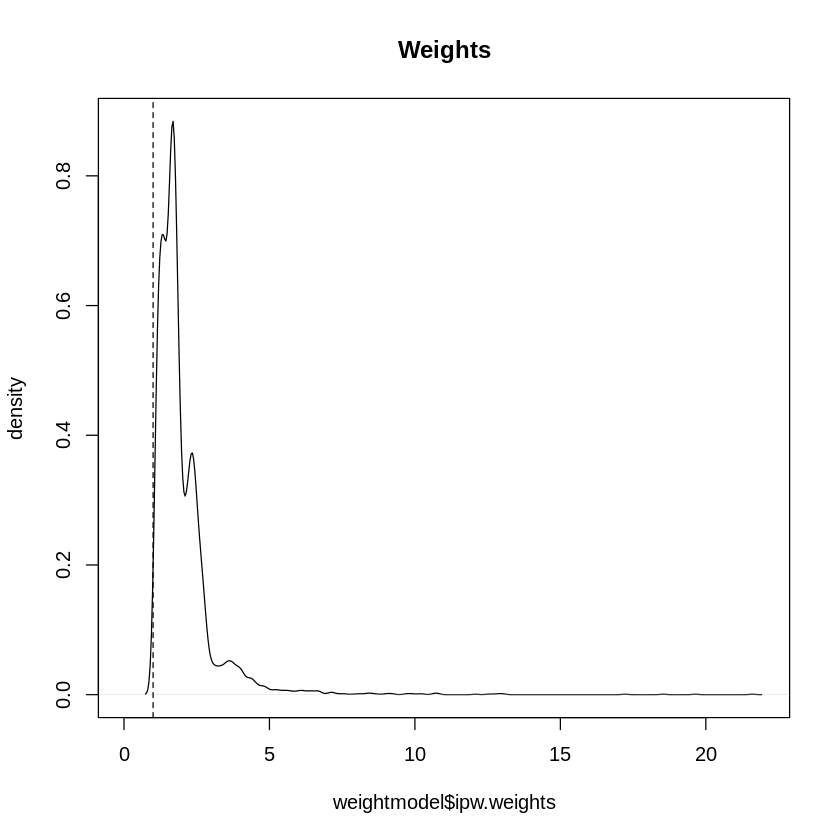

In [74]:
# Plot the distribution of weights
ipwplot(weights = weightmodel$ipw.weights, logscale = FALSE,
        main = "Weights", xlim = c(0, 22))


#Using svyglm in Survey Package
Here, the svyglm function from the survey package is used with a custom survey design that incorporates the weights.

In [75]:
# Ensure the survey package is loaded
library(survey)

# Step 1: Define a survey design object with IPW weights
# - '~ 1' specifies that there are no clusters (independent sampling)
# - 'weights = ~ wt' uses the weights column to account for the IPW
design <- svydesign(~ 1, weights = ~ weight, data = mydata)

# Step 2: Fit the marginal structural model (risk difference)
# This model estimates the causal risk difference for the treatment effect on death
msm <- svyglm(died ~ treatment, design = design, family = quasibinomial(link = "identity"))

# Step 3: View coefficients
coef(msm)

# Step 4: Get confidence intervals for the estimated parameters
confint(msm)


(Intercept)   treatment 
 0.63046375  0.05154951

,2.5 %,97.5 %
(Intercept),0.61401097,0.64691653
treatment,0.02332433,0.07977469


#Truncate Weights

## Method 1: Manually Truncate Weights
The replace function can be used to set a maximum cap on the weights. In this case, weights above 10 will be truncated to 10.


In [76]:
## Manually truncate weights at 10
truncweight <- replace(weight, weight > 10, 10)

# Fit a GLM with truncated weights to estimate the causal risk difference
glm.obj <- glm(died ~ treatment, weights = truncweight, data = mydata,
               family = binomial(link = "identity"))

# Display the results
summary(glm.obj)


Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”



Call:
glm(formula = died ~ treatment, family = binomial(link = "identity"), 
    data = mydata, weights = truncweight)

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) 0.630464   0.006375  98.895  < 2e-16 ***
treatment   0.054932   0.008863   6.198 5.72e-10 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 14675  on 5734  degrees of freedom
Residual deviance: 14637  on 5733  degrees of freedom
AIC: 14635

Number of Fisher Scoring iterations: 3


## Method 2: Truncate Weights Using the IPW Package

The IPW package allows you to specify truncation directly when calculating weights using ipwpoint.


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.081   1.405   1.721   1.972   2.280   6.379 

(Intercept)   treatment 
 0.63045533  0.05494865

,2.5 %,97.5 %
(Intercept),0.61400312,0.64690753
treatment,0.02822366,0.08167363


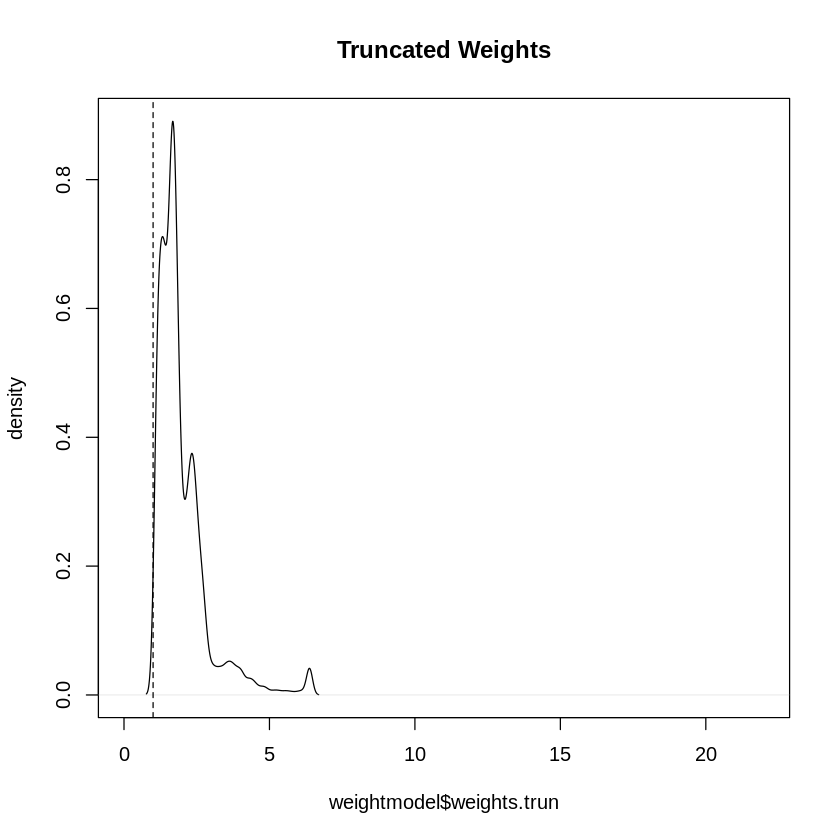

In [77]:
# Load the IPW package if not already installed
if (!requireNamespace("ipw", quietly = TRUE)) install.packages("IPW")
library(ipw)

# Step 1: Fit the IPW model with truncation at the 1st and 99th percentiles
weightmodel <- ipwpoint(exposure = treatment,
                        family = "binomial",
                        link = "logit",
                        denominator = ~ age + female + meanbp1 + ARF + CHF + Cirr +
                                      colcan + Coma + lungcan + MOSF + sepsis,
                        data = mydata,
                        trunc = 0.01)  # Truncates weights at the 1st and 99th percentiles

# Step 2: Summary of truncated weights
summary(weightmodel$weights.trun)

# Step 3: Plot the distribution of truncated weights
ipwplot(weights = weightmodel$weights.trun, logscale = FALSE,
        main = "Truncated Weights", xlim = c(0, 22))

# Step 4: Save the truncated weights to `mydata`
mydata$truncweight <- weightmodel$weights.trun

# Step 5: Fit a marginal structural model (MSM) with truncated weights for risk difference
# Define the survey design object using truncated weights
design <- svydesign(~ 1, weights = ~ truncweight, data = mydata)

# Fit the MSM using svyglm with identity link for risk difference
msm <- svyglm(died ~ treatment, design = design)

# View the coefficients and confidence intervals
coef(msm)
confint(msm)
